# MNIST Task

## Imports

In [1]:
# standard library
import os
import gzip
from urllib.request import urlretrieve

# Other
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

# EURNN
import sys; sys.path.append('..')
from torch_eunn import EURNN

## Constants

In [2]:
# Data parameters
num_labels = 10 # Number of different types of labels (1-10)
width, height = 28, 28 # width / height of the image
num_pixels = width*height

# pixel permutation idxs
perm_idxs = list(range(num_pixels))
np.random.RandomState(seed=0).shuffle(perm_idxs)

# reverse pixel permutation idxs
rev_perm_idxs = [perm_idxs.index(i) for i in range(num_pixels)]

# Training Parameters
num_steps = 40000 # Number of training steps to run
test_size = 10000 # Test data set size
valid_size = 10000 # Validation data set size
train_size = 60000 - valid_size # Size of the training set
batch_size = 100 # Batch size
test_batch_size = 1000 # batch size for calculating the validation/test loss

# RNN Parameters
num_inputs = 1 # input dimension [1=pixel-by-pixel]
num_steps_rnn = num_pixels // num_inputs # sequential dimensionality of rnn
num_hidden_rnn = 256 # hidden layer dimension
capacity_rnn = 2 # capacity of eunn

# Optimization parameters
learning_rate = 0.0001 # learning rate

# select device ('cuda' or 'cpu')
device = 'cuda' # highly recommended to take cuda!

## Data

### Fetch MNIST

A custom function to fetch the mnist data from its original source. This function downloads the data from [`http://yann.lecun.com`](http://yann.lecun.com) and saves it as `.npy` in the folder named `mnist_data`. The next time this function is called, the `.npy` files are loaded.

In [3]:
def fetch_mnist(redownload=False, verbose=True):
    ''' Get MNIST data in npy format

    Args:
        redownload=False (bool): force redownload, even if file already exists
    '''
    # check if data is already downloaded. If so, do not download again, except
    # when explicitly asked to do so
    if (os.path.exists('mnist_data/train.npy')
        and os.path.exists('mnist_data/test.npy')
        and not redownload):
        # load files from data folder
        return np.load('mnist_data/train.npy'), np.load('mnist_data/test.npy')

    # create folders
    if not os.path.isdir('mnist_data'):
        os.mkdir('mnist_data')

    # check if data is already downloaded. If so, do not download again, except
    # when explicitly asked to do so
    if not (os.path.exists('mnist_data/train_images.gz')
        and os.path.exists('mnist_data/train_labels.gz')
        and os.path.exists('mnist_data/test_images.gz')
        and os.path.exists('mnist_data/test_labels.gz')
        and not redownload):
        if verbose:
            print('downloading mnist data from http://yann.lecun.com/')
        # download data
        urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'mnist_data/train_images.gz')
        urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'mnist_data/train_labels.gz')
        urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 'mnist_data/test_images.gz')
        urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 'mnist_data/test_labels.gz')

    # fill numpy arrays:
    train = np.empty((60000,785), dtype='uint8')
    test = np.empty((10000,785), dtype='uint8')
    
    if verbose:
        print('extracting mnist data... (takes a while)')

    for type, npdata in [('train', train),('test', test)]:
        # open the files
        with gzip.open('mnist_data/%s_images.gz'%type, 'rb') as data,\
             gzip.open('mnist_data/%s_labels.gz'%type, 'rb') as labels:

            # skip the first bytes with metadata of the ubyte file:
            data.read(16)
            labels.read(8)

            # read each byte of the gzip file and save it as a uint8 number
            # in the numpy array.
            for i in range(npdata.shape[0]):
                npdata[i,0] = ord(labels.read(1))
                for j in range(784): # append the data after the label
                    npdata[i, j+1] = ord(data.read(1))

    # save numpy arrays
    np.save('mnist_data/train.npy', train)
    np.save('mnist_data/test.npy', test)
    
    if verbose:
        print('finished conversion.')

    return train, test

### Preprocess Data

We use the custom MNIST data fetcher defined above.

The image values are specified by an integer between 0 and 255. We convert these pixel values to a float between 0 and 1.

In contrast with the Convolutional Neural Networks, we do a pixel-by-pixel recognition of the digit image where the individial pixels are permuted with a fixed permutation defined by `perm_idx`. This fixed permutation is necessary for good performance of the RNN, as otherwise the the end of the pixel stream contains too many zeros for the RNN to retain its internal state. This is a good benchmark task for a recurrent neural network. The performance of this architecture will obviously be worse than for a convnet.

In [4]:
train_data, test_data = fetch_mnist()
data = np.vstack([train_data, test_data])
np.random.shuffle(data)

train_data = data[:-test_size-valid_size]
valid_data = data[-test_size-valid_size:-test_size]
test_data  = data[-test_size:]

def get_values_labels(data):
    labels = torch.tensor(data[:,0], dtype=torch.int64, device=device)
    values = torch.tensor(data[:,1:][:,perm_idxs]/255, dtype=torch.float32, device=device).view(-1, num_steps_rnn, num_inputs)
    return values, labels
    
train_values, train_labels = get_values_labels(train_data)
valid_values, valid_labels = get_values_labels(valid_data)
test_values, test_labels = get_values_labels(test_data)

print(f'train data shape:\t{train_values.shape}')
print(f'train labels shape:\t{train_labels.shape}')

train data shape:	torch.Size([50000, 784, 1])
train labels shape:	torch.Size([50000])


We can visualize the different digits by writing a visualization function that reshapes the 784D train and test values into a 28x28 grid:

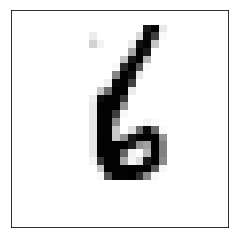

In [5]:
def show_digit(digit_array):
    plt.imshow(digit_array.cpu().numpy().reshape(num_pixels)[rev_perm_idxs].reshape(width, height), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
show_digit(train_values[31])

## Model

Let's now build a network with two convolutional layers, followed by two fully connected layers. We use the `torch.nn.Module` to create the network.

In [6]:
# Create RNN Model
class Model(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden_rnn, capacity_rnn, num_labels):
        super(Model, self).__init__()
        
        # RNN
        self.rnn = EURNN(num_inputs, num_hidden_rnn, capacity=capacity_rnn, batch_first=True)
        
        # Readout layer
        self.output_layer = torch.nn.Linear(num_hidden_rnn, num_labels, bias=True)
        
        # initialize weights
        v = np.sqrt(2)/np.sqrt(num_inputs+num_labels)
        self.rnn.input_layer.bias.data[:] = 0.01
        self.rnn.modrelu.bias.data[:] = 0.01
        self.output_layer.bias.data[:] = 0.01
        torch.nn.init.uniform_(self.rnn.input_layer.weight.data, -v, v)
        torch.nn.init.uniform_(self.output_layer.weight.data, -v, v)
        
        # move to device
        self.to(device)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.output_layer(out[:, -1, :]) 
        return out

## Train

Create the model

In [7]:
model = Model(num_inputs, num_hidden_rnn, capacity_rnn, num_labels)

We use the categorical cross entropy loss for training the model.

As optimizer we could use a Gradient Descent optimizer [with or without decaying learning rate] or one of the more sophisticated (and easier to optimize) optimizers like Adam or RMSProp

In [8]:
# loss
lossfunc = torch.nn.CrossEntropyLoss()

# accuracy
def accuracy(logits, labels):
    return 100*np.mean(np.argmax(logits.data.cpu().numpy(), 1) == labels.data.cpu().numpy())

# RMSprop Optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

Start the training

In [9]:
%%time
history = []

for step in range(num_steps):
    # reset gradients
    optimizer.zero_grad()
    
    # calculate validation accuracy and loss
    with torch.no_grad():
        if step%(train_size//batch_size) == 0 or step == num_steps - 1:
            val_acc = np.zeros(valid_size//test_batch_size)
            val_loss = np.zeros(valid_size//test_batch_size)
            # we need to split the calculation of the validation loss in batches
            # to avoid memory problems.
            for i in range(0, valid_size, test_batch_size):
                valid_logits = model(valid_values[i:i+test_batch_size])
                val_loss[i//test_batch_size] = lossfunc(valid_logits, valid_labels[i:i+test_batch_size]).item()
                val_acc[i//test_batch_size] = accuracy(valid_logits, valid_labels[i:i+test_batch_size]).item()
            history.append((step, val_loss.mean(), val_acc.mean()))
            print(f'Step {step:5.0f}\t Valid. Acc. = {val_acc.mean():5.2f}')

    # train
    idxs = np.random.randint(0, train_size, batch_size)
    batch_values = train_values[idxs]
    batch_labels = train_labels[idxs]
    logits = model(batch_values)
    loss = lossfunc(logits, batch_labels)
    loss.backward()
    optimizer.step()

Step     0	 Valid. Acc. =  6.66
Step   500	 Valid. Acc. = 71.99
Step  1000	 Valid. Acc. = 76.40
Step  1500	 Valid. Acc. = 78.62
Step  2000	 Valid. Acc. = 80.40
Step  2500	 Valid. Acc. = 81.32
Step  3000	 Valid. Acc. = 83.09
Step  3500	 Valid. Acc. = 83.55
Step  4000	 Valid. Acc. = 84.11
Step  4500	 Valid. Acc. = 85.48
Step  5000	 Valid. Acc. = 82.83
Step  5500	 Valid. Acc. = 86.59
Step  6000	 Valid. Acc. = 87.09
Step  6500	 Valid. Acc. = 86.70
Step  7000	 Valid. Acc. = 86.77
Step  7500	 Valid. Acc. = 87.67
Step  8000	 Valid. Acc. = 87.27
Step  8500	 Valid. Acc. = 86.74
Step  9000	 Valid. Acc. = 88.55
Step  9500	 Valid. Acc. = 88.33
Step 10000	 Valid. Acc. = 87.85
Step 10500	 Valid. Acc. = 88.05
Step 11000	 Valid. Acc. = 88.69
Step 11500	 Valid. Acc. = 89.28
Step 12000	 Valid. Acc. = 88.65
Step 12500	 Valid. Acc. = 89.48
Step 13000	 Valid. Acc. = 88.74
Step 13500	 Valid. Acc. = 89.28
Step 14000	 Valid. Acc. = 89.39
Step 14500	 Valid. Acc. = 89.51
Step 15000	 Valid. Acc. = 88.55
Step 155

Training history:

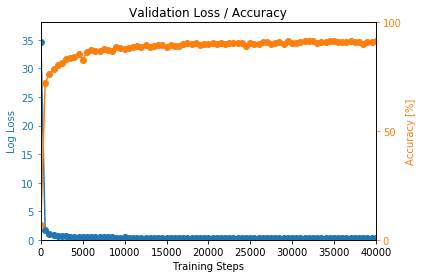

In [10]:
steps, loss, acc = zip(*history)

fig, ax_loss = plt.subplots()
ax_acc = ax_loss.twinx()

plt.sca(ax_acc)
plt.plot(steps, acc, '-o', color='C1')
plt.ylabel('Accuracy [%]', color='C1');
plt.tick_params('y', colors='C1')
m = (min(acc)-1)//10*10; plt.ylim(m,100)
plt.yticks([m,(m+100)//2,100])

plt.sca(ax_loss)
plt.plot(steps, loss, '-o', color='C0')
plt.ylabel('Log Loss', color='C0');
plt.tick_params('y', colors='C0')
m = 1.1*max(loss)
plt.ylim(0.01, m)

plt.xlim(0, (max(steps)+100)//100*100)
plt.xlabel('Training Steps')
plt.title('Validation Loss / Accuracy')
plt.show()

## Test

Finally, the accuracy on the test set can be evaluated:

In [11]:
with torch.no_grad():
    # we need to split the calculation of the test loss in batches
    # to avoid memory problems.
    test_accuracy = np.zeros(test_size//test_batch_size)
    for i in range(0, test_size, test_batch_size):
        test_logits = model(test_values[i:i+test_batch_size])
        test_accuracy[i//test_batch_size] = accuracy(test_logits, test_labels[i:i+test_batch_size]).item()
test_accuracy = test_accuracy.mean()
print(f'Test Accuracy = {test_accuracy:5.2f}')

Test Accuracy = 91.31


Visualize an example

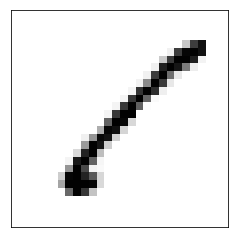

prediction=1	target=1


In [12]:
N = 315
show_digit(test_values[N])
test_logits = model(test_values[N:N+1])
prediction = torch.argmax(test_logits[0]).item()
target = test_labels[N].item()
print(f'prediction={prediction}\ttarget={target}')